# Lab05 Exercises #2

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Copied from Notebook 1

In [ ]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import rasterio as rio
import rasterio.plot

In [ ]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#May want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

In [ ]:
pwd

'/home/jovyan/src/gda_course_2023_solutions/modules/05_Raster1_GDAL_rasterio_LS8'

In [ ]:
#Set path to local directory with downloaded images
imgdir = '/home/jovyan/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8/LS8_sample'

In [ ]:
#Pre-identified cloud-free Image IDs used for the lab
#Summer 2018
img_id1 = 'LC08_L2SP_046027_20180818_20200831_02_T1'
#Winter 2018
img_id2 = 'LC08_L2SP_046027_20181224_20200829_02_T1'

In [ ]:
#Scale and offset values for L2 Landsat products
#Surface Reflectance 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2

In [ ]:
#Define image to use (can set this to switch to winter image)
img = img_id1

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_SR_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_SR_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_SR_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_SR_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_SR_B6.TIF')

### Fetch Panchromatic band from Google Cloud archive (not avilable from MS Planetary Computer)

In [ ]:
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

In [ ]:
#Define Landsat path/row for Western Washington
path = 46
row = 27

#Get Panchromatic band only
b = 8

#Pre-identified cloud-free Image IDs for this path/row 
#Summer 2018
img_id1_l1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2_l1 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

img_list = (img_id2_l1, img_id1_l1)
#img_list = (img_id1,)

In [ ]:
#Loop through all selected images and bands
for img in img_list:
    #for b in range(1,12):
    #Generate the appropriate URL for the images we identified
    image_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
    print(image_url)
    #Local filename
    out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    #Check to see if file already exists
    if not os.path.exists(out_fn):
        print("Saving:", out_fn)
        #Download the file
        urllib.request.urlretrieve(image_url, out_fn)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20181224_20190129_01_T1/LC08_L1TP_046027_20181224_20190129_01_T1_B8.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B8.TIF


In [ ]:
#Panchromatic
p_fn = os.path.join(imgdir, img_id1_l1+'_B8.TIF')

In [ ]:
#Sanity check
#Leave these Datasets open for use later in lab (e.g., extracting resolution)
p_src = rio.open(p_fn)
print("Pan", p_src.profile)
r_src = rio.open(r_fn)
print("MS Red Band", r_src.profile)

Pan {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 15561, 'height': 15761, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(15.0, 0.0, 473392.5,
       0.0, -15.0, 5373307.5), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
MS Red Band {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Note the width and height values for 15 m Pan band - these are different than the 30 m products for the same image

## Part 5: Raster window extraction

## Rasterio window
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`
* Let's define 1024x1024 px windows around Mt. Rainer and Seattle

In [ ]:
import rasterio.windows

#These are windows for Pan band, need to scale for others

#Mt. Rainier
window = rasterio.windows.Window(3600, 5600, 1024, 1024)

#Seattle
#window = rasterio.windows.Window(2100, 2800, 1024, 1024)

In [ ]:
#Define window bounds for Pan 
window_bounds = rasterio.windows.bounds(window, p_src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (527392.5, 5273947.5, 542752.5, 5289307.5)
Window extent:  [527392.5, 542752.5, 5273947.5, 5289307.5]


### Define a function to read only this subwindow into an array
* I provided sample code here, but please review so you understand each step

In [ ]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

### Use this function to read the Mt. Rainier window from the Panchromatic band
* Store as a new array
* Note that our original window dimensions were 1024x1024, but the logic in the function above scales for the 15 m Panchromatic band, so we get a 2048x2048 px array

In [ ]:
#Student Exercise

(2048, 2048)


masked_array(
  data=[[7170., 7073., 7136., ..., 7464., 7544., 7581.],
        [7042., 6762., 6863., ..., 7480., 7494., 7548.],
        [6808., 6789., 6757., ..., 7505., 7553., 7629.],
        ...,
        [6834., 6758., 6821., ..., 7614., 7552., 7450.],
        [6788., 6789., 6833., ..., 7555., 7247., 7251.],
        [6761., 6799., 6821., ..., 7553., 7396., 7347.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

### Display the windowed Panchromatic band with matplotlib imshow
* Use the 'gray' colormap
* Pass the `window_extent` to imshow
    * My sample code above already calculated and stored this variable for you!
* Add a scalebar

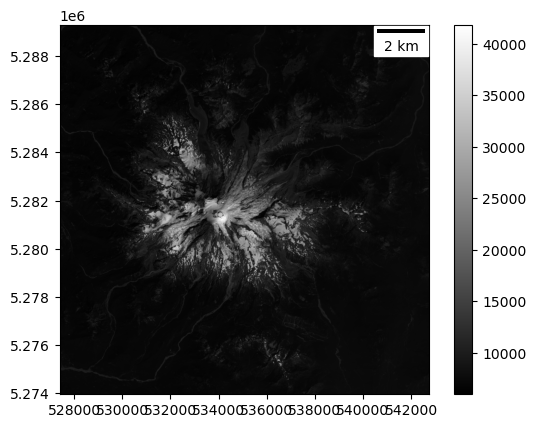

In [ ]:
#Student Exercise

## Part 6: Contrast Enhancement
### Create a quick histogram for the window array
* This will help you visualize the range of DN values
* Remember to use the numpy masked array `compressed()` function to remove the nodata values before generating your histogram, and use enough bins to capture the true distribution without aliasing

In [ ]:
#Student Exercise

### Write a function to normalize (AKA contrast stretch) input Panchromatic image array values
OK, this might seem intimidating at first, but you can do it!  Please ask for help if you're confused after reading through these instructions...
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)
    * Let's use the simple rescaling "min-max normalization" here: https://en.wikipedia.org/wiki/Feature_scaling
* So we need a function to remap the input DN values from 0-65535 to the output range 0-1
    * Simplest approach would be to map 0 -> 0 and 65535 -> 1, so just divide our original values by 65535
    * But we want to improve contrast, and scale over the actual range of values in our dataset
    * One option is to use the actual min and max values in the array, mapping `array.min()` -> 0 and `array.max()` -> 1
        * To do this, we need to account for an offset (`array.min()`) and scaling factor (`array.max() - array.min()`)
    * However, there could some outlier values (very bright or very dark pixels) as min and max, leaving poor contrast over most valid pixels in the image. So a more robust contrast enhancement is to use the 2nd and 98th percentile DN values as the min and max values for the rescaling step:
        * See https://numpy.org/doc/stable/reference/generated/numpy.percentile.html
            * Remember, if your input is a masked array, you want to pass in `my_array.compressed()`
        * The DN value of the 2nd percentile should map to 0
        * The DN value at the 98th percentile should map to 1
        * Note that we will now have some values less than 0 and some values greater than 1 in the output! This is fine.
            * Optional - add a step to "clip" the remapped values, so that any values less than 0 are set to 0, and any values greater than 1 are set to 1
                * See https://numpy.org/doc/stable/reference/generated/numpy.ma.clip.html
    * Consider accepting the min and max percentile values as arguments to your function, so you can experiment with different percentiles when you call the function later in the notebook and plot resulting array
* Your function should return a new array (with `float` dtype) and values distributed over the (0.0-1.0) range
* Take some time to think this through, discuss with others, and sanity check your output

In [ ]:
#Student Exercise

### Use your function to contrast stretch the window array and plot
* You should see enchanced contrast compared to your earlier plot
* Note: the new array values are from 0-1, so if you did not `clip` values in your normalization function, you will need to specify `vmin=0, vmax=1` in your `imshow` call to visualize your new contrast stretch
* If some areas of the image appear too dark or too bright, you can experiment with adjusting the `vmin` or `vmax` values to improve contrast over the appropriate range of values
    * For example, try `vmax=0.1` to bring out more detail over dark vegetation at the expense of saturating the bring snow/ice
    * This is one of the reasons we want higher bit depth for cameras - it allows you to fully capture more of the full range of brightness values in the scene, so you can customize contrast enhancement later

In [ ]:
#Student Exercise

Input range: (5955.0, 41855.0)
Percentile range (2, 98): (6474.0, 24048.0)
Output range: (0.0, 1.0)


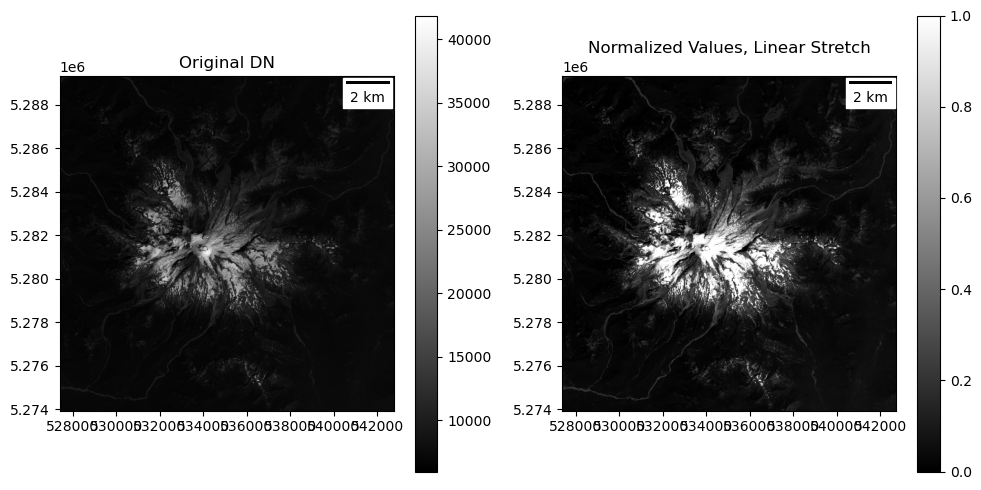

In [ ]:
#Student Exercise

### Extra Credit: try non-linear contrast stretch
* This image has some very bright pixels (snow/ice) and some very dark pixels (water, conifers)
* By default, passing in `vmin` and `vmax` uses a linear contrast stretch during rendering, but there are other nonlinear options
* Read more here about the available matplotlib normalization approaches: https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    * Try LogNorm to see if you can bring out more detail in bright and dark regions 
        * https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LogNorm.html
        * Note that you can't use `vmin=0` here (what's the log of 0?), but should use something like `vmin=0.01` to start
* Can also try some of the "histogram equalization" approaches for nonlinear stretching, implemented in the `scikit-image` package or computer vision packages like `opencv`:
    * https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
    * https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html

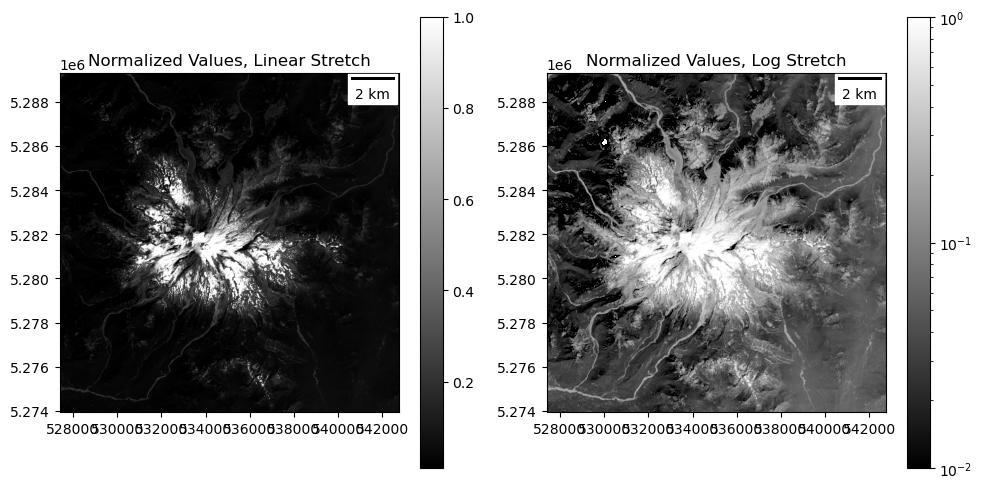

In [ ]:
#Student Exercise

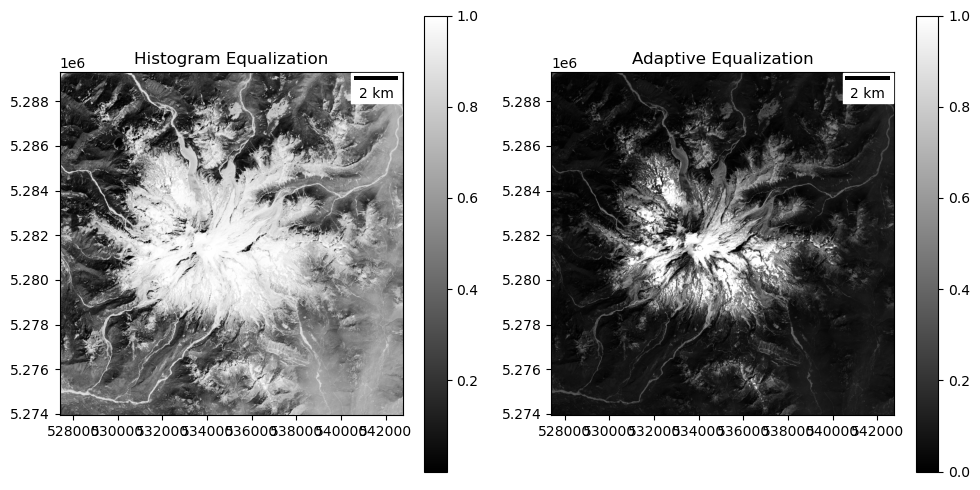

In [ ]:
#Student Exercise

## Part 7: Composite images
* http://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html

### Create a natural "true" color RGB (red, green, blue) composite for this window
* This represents "true" color, closer to what your eye would see
* Use the `rio2ma` function to load the same window from the red, green and blue band tif files
    * ⚠️ Make sure you pass in the window, and don't try to load the full images here!  Can potentially fill RAM on your Jupyterhub server, leading to kernel restart!
* Then normalize each channel independently using your `norm` function
    * Note: the `rio2ma` function at the beginning of the notebook applies the appropriate Level 2 scaling/offset values to obtain surface reflectance values for Bands 1-7 (visible and near-IR) in the 0.0-1.0 range
    * Based on the requirements outlined earlier, this additional normalization step will apply a stretch between the 2nd and 98th percentile values (approximately 0 and 0.5 for scaled values), giving you improved contrast for the actual distribution of values
        * Note: considering all of the dark trees in this scene, you might consider using the 0 percentile as the minimum and something like the 95th percentile for the maximum. This is what I used for my RGB plots. If your normalization function accepts these percentile values as arguments, should be easy to experiment with this.
* Use numpy `dstack` to combine as a 3D array
    * https://numpy.org/doc/stable/reference/generated/numpy.dstack.html
    * Be careful of the band order here!
    * Sanity check: final array shape should be (1024, 1024, 3)

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

### Plot the natural color composite
* Pass the 3-band array to `imshow`
    * Because this is such a common image format (just think about all of the RGB photos of cats on the web), `imshow` can recognize this as a 3-band array and plot, assuming values are red, green, and blue channels!
    * See doc here for (M, N, 3) array input: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
* Pass the relevant `extent` to imshow so your coordinate axes labels are meteres in preojected CRS
* Add a scalebar
* Things should start to look more normal:
    * Trees should appear dark green
    * Snow: white
    * Exposed glacier ice: light blue
    * Exposed rock (or debris-covered ice): brown

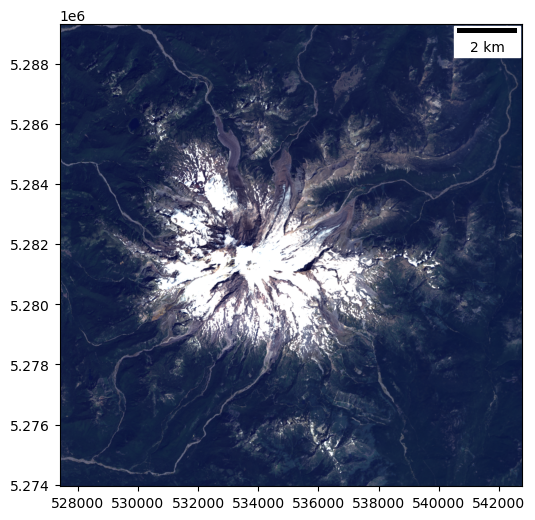

In [ ]:
#Student Exercise

### Create a color-infrared (CIR) composite and plot
* Load the same window from the Near-IR band
* Look up the band combination required here and be careful with order passed to `dstack`
    * http://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html
* Sanity check: vegetation should appear red
    * Deciduous (leafy) vefetation will appear bright red
    * Coniferous (evergreen) vegetation will appear darker red

In [ ]:
#Student Exercise

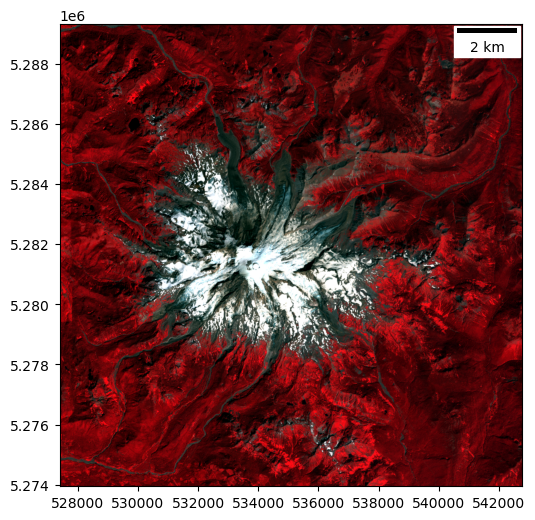

In [ ]:
#Student Exercise

### Create a combined figure with subplots for PAN, RGB composite, and CIR composite
* Use the `plt.subplots()` with appropriate number of rows and columns
    * https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    * Use the `sharex` and `sharey` options - this will "link" the extent of the three subplots, so if you zoom/pan in one, the others will update to match!
        * Note how shared tick labels are dropped here
    * Set an appropriate `figsize` in inches - something like (12,4) might work
* Pass the projected bounds to each imshow `extent` option
* Use `gray` colormap for the PAN, you shouldn't need to specify a colormap for the RGB or CIR
* Add a scalebar to the first subplot
* Add appropriate titles to each subplot
* Use `plt.tight_layout()` to clean up axes: https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html

In [ ]:
#%matplotlib widget

Input range: (5955.0, 41855.0)
Percentile range (2, 98): (6474.0, 24048.0)
Output range: (0.0, 1.0)


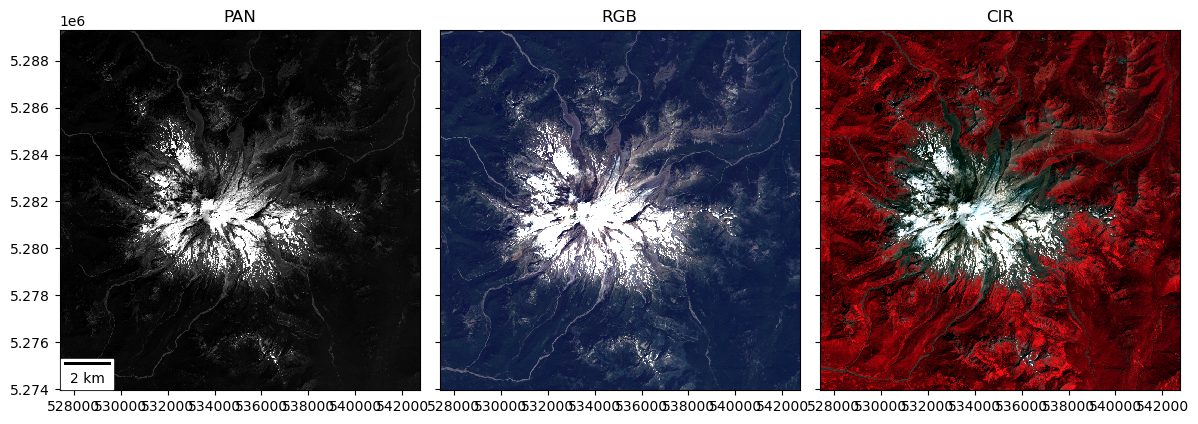

In [ ]:
#Student Exercise

### Interactive Analysis
* You made this beautiful plot, now explore a bit!
* If you're not using already, switch to `%matplotlib widget` backend and rerun the above cell to create an interactive version of the PAN/RGB/CIR plot
* Zoom all the way in until you see individual pixels
    * Note the difference in resolution between the 15-m PAN and 30-m RGB/CIR images
        * Another note: there may be some slight offsets between the Pan and RGB images due to the fact that we are mixing Level 1 and Level 2 data, respectively - some improvements to geolocation in the Level-2 products.
    * Note how the scalebar updates (sanity check your pixel sizes here of 15 m and 30 m, if incorrect, probably an issue with your `ScaleBar` or `extent`)
* Note the changing values for (x,y) coordinates and the DN value(s) in the lower right corner of your plot
    * Should be 1 value when cursor is over PAN axes, 3 values for RGB and CIR axes
    * Check out values for snow, ice, exposed rock, forests
    * All values should be in the range of 0-1, because you already normalized each channel
* Experiment with some different interpolation methods for `imshow` display
    * https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * At least try `'neareset'`, `'bilinear'`, `'bicubic'`

### Extra Credit: Create a plot comparing different interpolation methods for identifiable features
* Can zoom in on Paradise to see roads, buildings, cars/RVs
    * Here is corresponding high-resolution aerial imagery from Google: https://goo.gl/maps/YaUWLTXZBf7vTukYA
* Note how interpolation method affects your ability to resolve features in the images 
* This sample code might be useful (though you don't have do all of these, maybe pick  a subset): https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * Note `'none'`, `'None'` and `'nearest'` are identical

In [ ]:
#Paradise area with roads, parking lots, buildings
#RGB 30 m
#subwindow = rgb[775:825,450:500]
#Panchromatic 15 m
subwindow = p[1525:1625,925:1025]

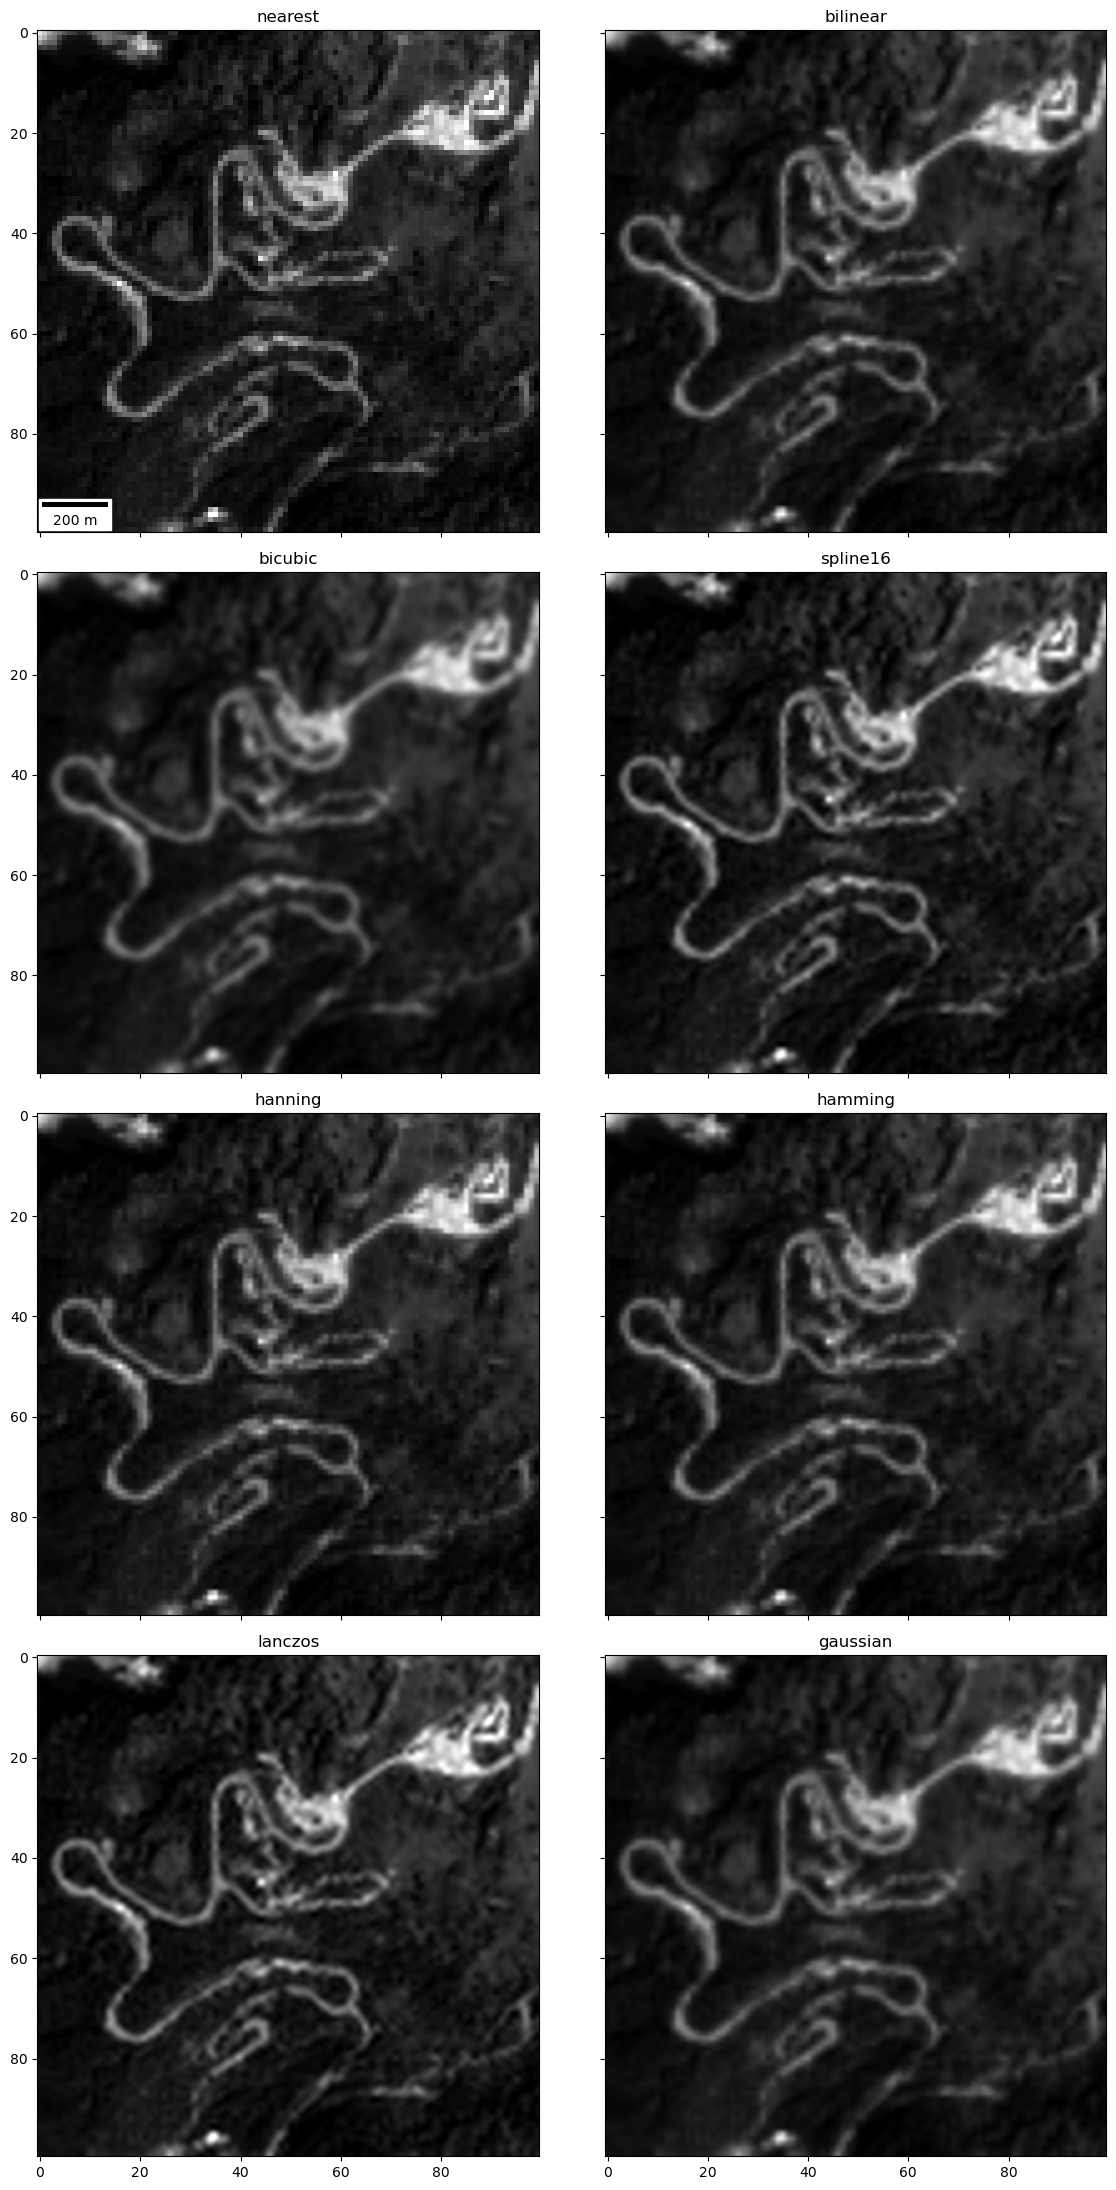

In [ ]:
#Student Exercise

## Part 8: Raster band math and index ratios
* Let's use some common band ratios to classify vegetation, snow and water for our window
* NOTE: if you're using `UInt16` masked arrays here, you will want to first convert each to `float`, as some addition/subtraction operations could result in values outside of 0-65536 (e.g., areas that are bright in all visible bands, like snow).
    * Can use `myarray.astype(float)` for this
    * If you don't do this, you will end up with "wrapping" artifacts

In [ ]:
#Load and convert the swir channel as well
swir = rio2ma(swir_fn, window=window)

### NDVI (normalized difference vegetation index)
* Resources:
    * https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
    * https://eos.com/ndvi/
* Create a new array to store the computed NDVI from the bands you've already loaded
* This should be simple - basic raster band math using NumPy arrays
    * Compute the ratio using the surface refletance values
    * Optional: use `np.ma.clip` to limit the output values to the (-1, 1) range, https://numpy.org/doc/stable/reference/generated/numpy.ma.clip.html
        * Otherwise, explicitly set `vmin=-1, vmax=1` in the imshow calls
* Plot and inspect
    * Plot original ndvi
    * Plot contrast-stretched ndvi using your normalization function above
    * Do you see different NDVI values for dense conifer trees (most of the scene) vs. open meadows or recently logged plots dominated by grass and other deciduous plants?

In [ ]:
#Student Exercise

In [ ]:
ndvi = np.ma.clip(ndvi, -1, 1)

Input range: (-1.0, 1.0)
Percentile range (2, 98): (-0.0907609649002552, 0.9090591073036194)
Output range: (0.0, 1.0)


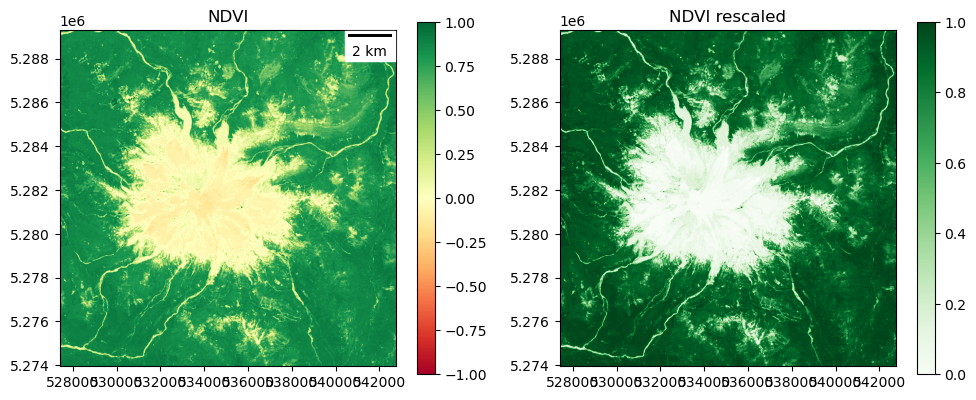

In [ ]:
#Student Exercise

### NDSI (normalized difference snow index)
* There are multiple definitions of NDSI in the literature, but let's use this one (using SWIR, since we have it available with LS-8):
    * https://eos.com/ndsi/

In [ ]:
#Student Exercise

Input range: (-1.0, 1.0)
Percentile range (2, 98): (-0.6034330129623413, 0.9368685185909271)
Output range: (0.0, 1.0)


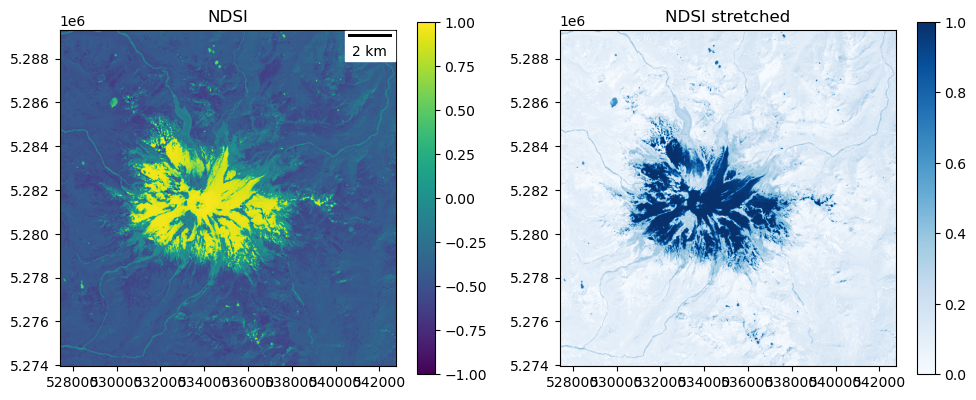

In [ ]:
#Student Exercise

### NDWI (normalized difference water index)
* Again, multiple definitions for different sensors.  Let's use the formula for surface water bodies (not leaves):
    * https://en.wikipedia.org/wiki/Normalized_difference_water_index


In [ ]:
#Student Exercise

Input range: (-1.0, 1.0)
Percentile range (2, 98): (-0.8214715421199799, 0.06016506440937519)
Output range: (0.0, 1.0)


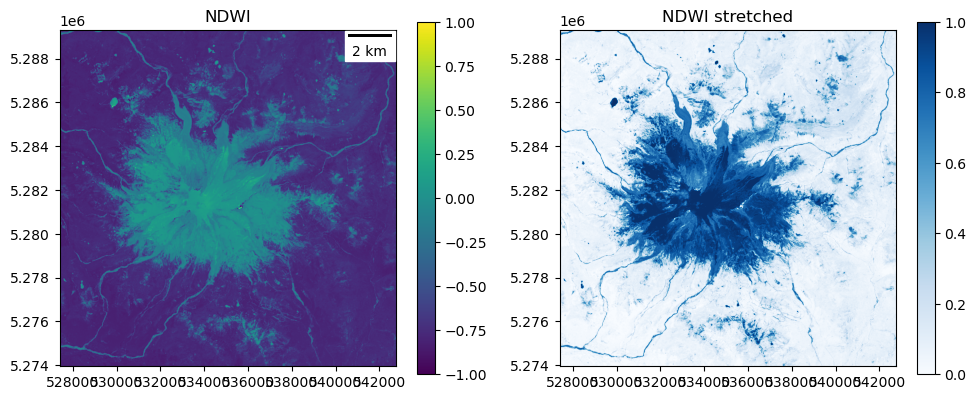

In [ ]:
#Student Exercise

### Extra Credit: create a figure with linked RGB, CIR, NDVI, NDSI, and NDWI products
* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
    * Zoom in on some vegetation, snow near the summit, and surface water like Mowich Lake (https://goo.gl/maps/V6YFJQPcfrDi9UXH6)
* Note how the different indices change (see interactive values for cursor position on each subplot), which should hopefully provide better sense of what the different indices are showing

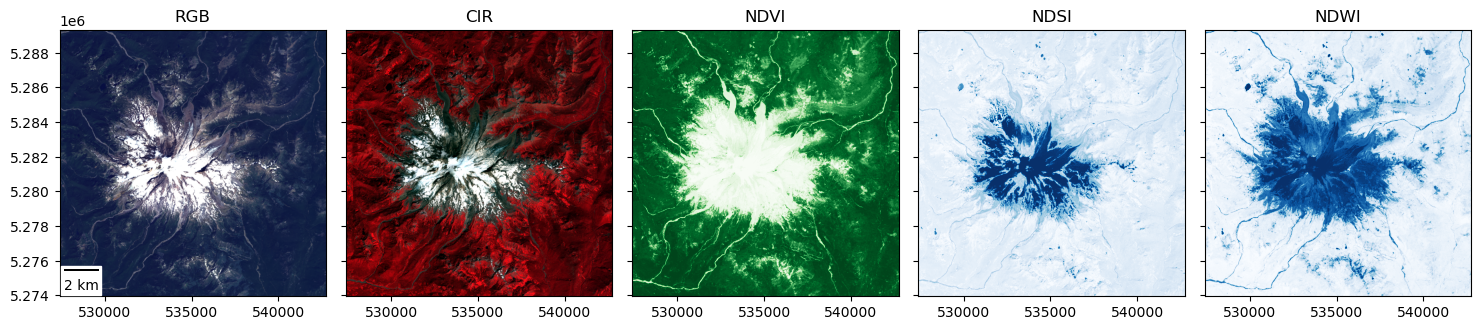

In [ ]:
#Student Exercise

## Part 9: Raster Classification Using Threshold
### Create a binary vegetation mask
* Need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDVI values above this threshold will be classified as "vegetation"
    * NDVI values below this threshold will be classified as "not vegetation"
    * This might be a useful resource: https://eos.com/ndvi/
* To decide on a threshold, probably useful review your NDVI plot above and maybe create plot a histogram of NDVI values
* Output mask should be boolean (True/False)
    * Should be true (1) for vegetation pixels and false (0) for all other pixels
* Create a figure with two subplots to show the NDVI map and your corresponding vegetation mask

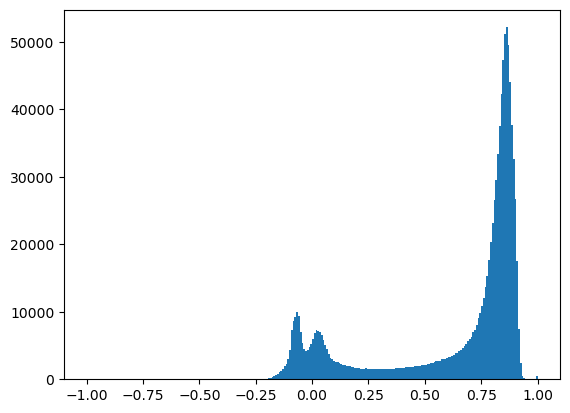

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

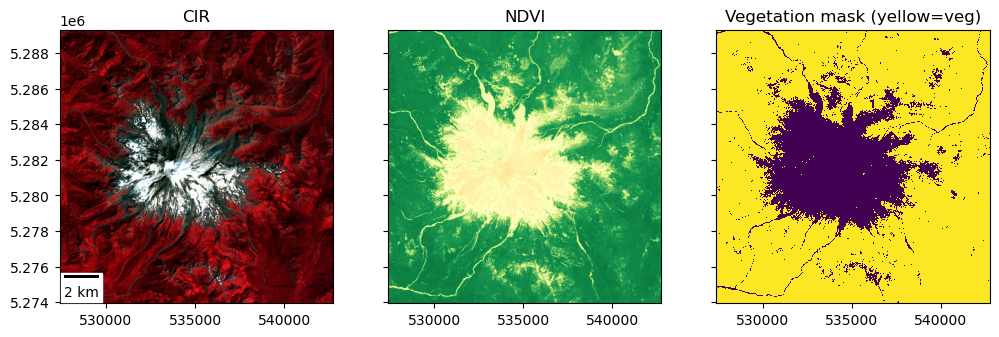

In [ ]:
#Student Exercise

### Create a binary snow mask
* Follow a similar procedure with thresholding to create a snow mask from NDSI
* Plot a histogram and experiment with your own values until you find a threshold that looks good based on snow extent observed in RGB image

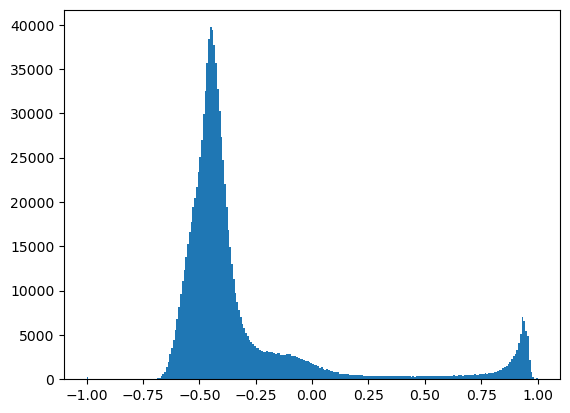

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

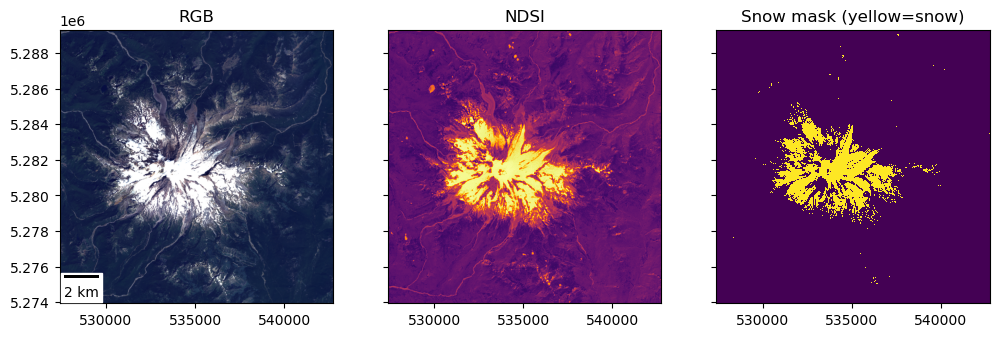

In [ ]:
#Student Exercise

## Part 10: Raster Area Calculation

### Use your snow mask to estimate the area (km<sup>2</sup>) covered by snow
* You will need to count the number of True (1) values in your boolean snow mask
* Think about this for a moment
* Remember, that your raster is a regular grid, and you know the dimensions of each grid cell in meters
    * Start by calculating the area covered by an indvidual pixel in square meters
    * Count the number of pixels classified as snow in your boolean snow mask
        * A few ways to approach this - the values we are interesed in are all set to 1, and everything else is 0, maybe a sum would work?  Or maybe count the number of nonzero values?
    * Multiply the two!
* Sanity check: look at the RGB image, your snow mask, and estimate the percentage of the windowed area (~31 x 31 km) covered by snow
    * Hint: Snow-covered area of ~60-70 km<sup>2</sup> seems reasonable
* *Note: Based on what we learned in our earlier lab on CRS/projections, this calculation should really be done using an equal-area projection. Fine to estimate with default UTM projection here, and we will cover raster reprojection in the Raster 2 lab.*

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

Snowcover: ~66 km^2


## Summary
We covered a lot of raster fundementals during this lab using a sample image from Landsat-8 over western Washington state. 

* Working with raster data in the cloud and downloading data on the fly
* Inspecting rasters with GDAL and rasterio
* Reading rasters into NumPy arrays and handling nodata
* Using the raster transform to convert between image/array and projected coordinates
* Visualizing rasters using corresponding projected coordinate system extent and scalebar
* Reading a small window from a large raster
* Raster DN value normalization and contrast enhancement
* Raster multi-band composite creation
* Raster visualization interpolation methods
* Raster band math and standardized index (e.g., NDVI) calculation 
* Raster classification using a thresholding
* Raster area calculation

All of these are common tasks in production and analysis workflows for rasters. Hopefully you can recognize the power of these simple techniques to efficiently extract meaningful quantitative information from raster data. We will revisit several of these concepts during the Raster2 lab and they will provide the foundation needed to explore `xarray` and `rioxarray`.

## Extra Credit
1. Repeat some of the above analysis for Seattle. You’ll need to redefine the window to use for extraction (this is commented out in earlier cell). Zoom in on UW campus - can you identify familiar landmarks?  Can you find your neighborhood park?
2. Repeat the above Mt. Rainier analysis for the cloud-free December 28, 2018 winter image defined early in the notebook (should already be downloaded). Or identify some other cloud-free imagery to explore! 
    * Create difference maps and do some basic analysis of how NDVI and snow-covered area changed between the summer and winter images.

In [ ]:
#Student Exercise